# Analysis

In [1153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from statsmodels.formula.api import ols
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from scipy.stats import kruskal

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [1154]:
rail_df = pd.read_csv('alltransit-railridership_cleaned.csv', encoding='utf-8')
rail_df.head()

,Agency,Mode/Type of Service Status,UZA Name,Mode,TOS,Year,UPT,VRM,Organization Type,city,...,Avg Fares Per Trip FY,rank,score,tci,jobs,trips/week,routes,transit shed (mi2),%transit,population
0,King County,Inactive,"Seattle--Tacoma, WA",LR,DO,2002,357935,39630,"City, County or Local Government Unit or Depar...",Seattle,...,0.553756,95,8.3,4.9,403896,4783,19,38,0.214,734731
1,Tri-County Metropolitan Transportation Distric...,Active,"Portland, OR--WA",LR,DO,2002,25665600,3198863,Independent Public Agency or Authority of Tran...,Portland,...,0.898112,127,8.1,2.6,218492,3517,10,44,0.109,641885
2,City of Seattle,Active,"Seattle--Tacoma, WA",MG,PT,2002,2048787,220116,"City, County or Local Government Unit or Depar...",Seattle,...,2.910862,95,8.3,4.9,403896,4783,19,38,0.214,734731
3,Central Puget Sound Regional Transit Authority,Active,"Seattle--Tacoma, WA",CR,PT,2002,672495,286613,Independent Public Agency or Authority of Tran...,Seattle,...,2.850825,95,8.3,4.9,403896,4783,19,38,0.214,734731
4,Massachusetts Bay Transportation Authority,Inactive,"Boston, MA--NH",CR,DO,2002,40569600,22747143,Independent Public Agency or Authority of Tran...,Boston,...,3.169348,13,9.1,7.1,732061,5983,14,68,0.306,665942


In [1155]:
rail_df.columns

Index(['Agency', 'Mode/Type of Service Status', 'UZA Name', 'Mode', 'TOS',
       'Year', 'UPT', 'VRM', 'Organization Type', 'city', 'state',
       'UZA SQ Miles', 'UZA Population', 'Service Area Population',
       'Service Area SQ Miles', 'Avg Trip Length FY', 'Fares FY',
       'Operating Expenses FY', 'Avg Cost Per Trip FY',
       'Avg Fares Per Trip FY', 'rank', 'score', 'tci', 'jobs', 'trips/week',
       'routes', 'transit shed (mi2)', '%transit', 'population'],
      dtype='object')

### Which transit agencies have the highest ridership? What’s the agency with the highest ridership per state? Which cities has the highest ridership per capita?

In [1157]:
# Transit Agencies with the highest ridership
# UPT: Total # of persons who've boarded a railway

# .apply(lambda x: f'{x:,}') | Add comma formatting

q1_mostRidership = rail_df.groupby(['Agency','city'])['UPT'].sum().sort_values(ascending=False).astype('Int64').apply(lambda x: f'{x:,}').to_frame().reset_index()
q1_mostRidership.head(10)

,Agency,city,UPT
0,Massachusetts Bay Transportation Authority,Boston,"5,302,250,865"
1,Washington Metropolitan Area Transit Authority,Washington,"5,249,483,547"
2,Chicago Transit Authority,Chicago,"4,299,462,519"
3,Southeastern Pennsylvania Transportation Autho...,Philadelphia,"3,164,852,196"
4,San Francisco Bay Area Rapid Transit District,Oakland,"2,315,514,732"
5,MTA Long Island Rail Road,New York,"2,143,060,547"
6,New Jersey Transit Corporation,Newark,"2,119,341,935"
7,Los Angeles County Metropolitan Transportation...,Los Angeles,"1,980,659,087"
8,"Metro-North Commuter Railroad Company, dba: MT...",New York,"1,699,575,885"
9,Port Authority Trans-Hudson Corporation,New York,"1,656,219,248"


In [1158]:
# Agencys with highest ridership of their state
q1_ridershipByState = rail_df.groupby(['state','Agency'])['UPT'].sum().sort_values(ascending=False).astype('Int64').to_frame()

one_state, dropIndices = set(), []
for rail in q1_ridershipByState.index:
    if rail[0] not in one_state:
        one_state.add(rail[0])
    else:
        dropIndices += [rail]
q1_ridershipByState = q1_ridershipByState.drop(dropIndices).reset_index()

print(f'States with rails: {len(q1_ridershipByState)}')
q1_ridershipByState.head()

States with rails: 34


,state,Agency,UPT
0,MA,Massachusetts Bay Transportation Authority,5302250865
1,DC,Washington Metropolitan Area Transit Authority,5249483547
2,IL,Chicago Transit Authority,4299462519
3,PA,Southeastern Pennsylvania Transportation Autho...,3164852196
4,CA,San Francisco Bay Area Rapid Transit District,2315514732


In [1159]:
# Ridership per capita
q1_ridershipByCapita = rail_df[['city','state','trips/week','population']].drop_duplicates()
q1_ridershipByCapita['Yearly Ridership per Capita'] = q1_ridershipByCapita['trips/week']*52 / q1_ridershipByCapita['population']
q1_ridershipByCapita = q1_ridershipByCapita.sort_values('Yearly Ridership per Capita', ascending=False)
q1_ridershipByCapita.head()

,city,state,trips/week,population,Yearly Ridership per Capita
7,Newington,CT,2451,30458,4.184516
18,Johnstown,PA,1171,18422,3.305396
9,Camden,NJ,2469,71799,1.788159
756,Morgantown,WV,1132,33409,1.761920
60,San Carlos,CA,837,28846,1.508840


### How has ridership changed over time since 2002 across the US as a whole and by city? Will cities that have seen an increase in ridership have a higher AllTransit Score

In [1161]:
# Overall US Ridership
q2_ridershipOvertime = rail_df.groupby('Year')['UPT'].sum().astype('int64')

# q2_ridershipOvertime.head()
q2_ridershipOvertime[2020]

786496517

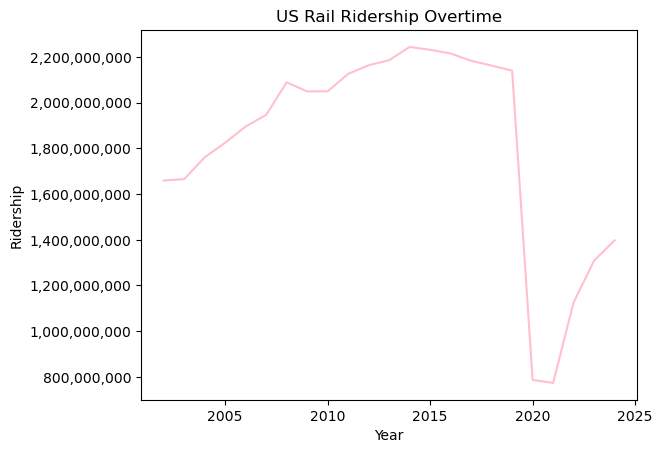

In [1162]:
plt.plot(q2_ridershipOvertime.index, q2_ridershipOvertime, color='pink')
plt.title('US Rail Ridership Overtime')
plt.xlabel('Year')
plt.ylabel('Ridership')
plt.gca().yaxis.set_major_formatter('{:,.0f}'.format)
plt.show()

In [1163]:
# Ridership per State
q2_ridershipOvertimebyState = rail_df.groupby(['Year','state'])['UPT'].sum().astype('int64').reset_index()

print(f'States: {len(q2_ridershipOvertimebyState['state'].unique())}')
q2_ridershipOvertimebyState.head()

States: 34


,Year,state,UPT
0,2002,CA,250618450
1,2002,CO,10429571
2,2002,CT,340626
3,2002,DC,244548262
4,2002,FL,21950973


In [1164]:
# Pruning states by total ridreship to 10 states, 34 is too many to display
q2_statefilter = set(rail_df.groupby('state')['UPT'].sum().sort_values(ascending=False).reset_index().head(10)['state'])

q2_statefilter

{'CA', 'DC', 'GA', 'IL', 'MA', 'NJ', 'NY', 'OR', 'PA', 'TX'}

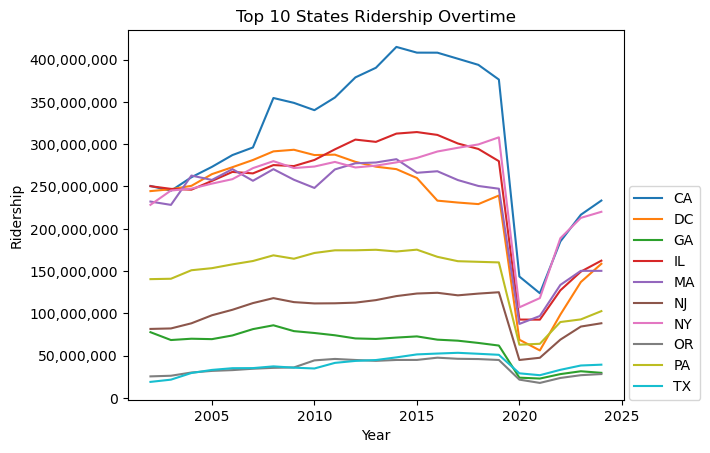

In [1165]:
for state in tuple(q2_ridershipOvertimebyState['state'].unique()):
    if state in q2_statefilter:
        dataframe = q2_ridershipOvertimebyState[q2_ridershipOvertimebyState['state'] == state]
        plt.plot(dataframe['Year'], dataframe['UPT'], label=state)
plt.title('Top 10 States Ridership Overtime')
plt.gca().yaxis.set_major_formatter('{:,.0f}'.format)
plt.xlabel('Year')
plt.ylabel('Ridership')
plt.legend(loc=(1.01,0))
plt.show()

In [1166]:
q2_ridershipOvertime = q2_ridershipOvertime.reset_index()

q2_ridershipOvertime.head(3)

,Year,UPT
0,2002,1659534986
1,2003,1665829263
2,2004,1761216642


C:\Users\staro\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


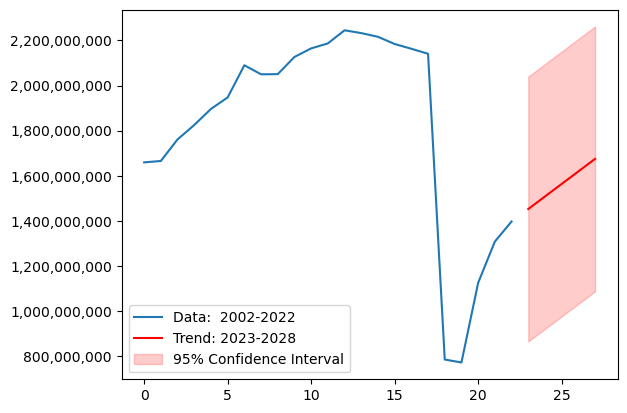

In [1167]:
# US UPT Forecast Data Prep
forecast_horizon = 5
values = q2_ridershipOvertime['UPT']

model = ExponentialSmoothing(values, trend='add').fit(optimized=True)
forecast = model.forecast(forecast_horizon)
forecast_variance = np.var(model.fittedvalues - values)
std_error = np.sqrt(forecast_variance)
ci_upper = forecast + 1.96*std_error
ci_lower = forecast - 1.96*std_error

plt.plot(values, label='Data:  2002-2022')
plt.plot(forecast, color='red', label='Trend: 2023-2028')
plt.fill_between(
    forecast.index,
    ci_lower,
    ci_upper,
    color='red',
    alpha=0.2,
    label='95% Confidence Interval',
)
plt.legend(loc='lower left')
plt.gca().yaxis.set_major_formatter('{:,.0f}'.format)
plt.show()

### How does access to jobs impact transit ridership? Do cities with more jobs accessible to public transit have higher ridership?  

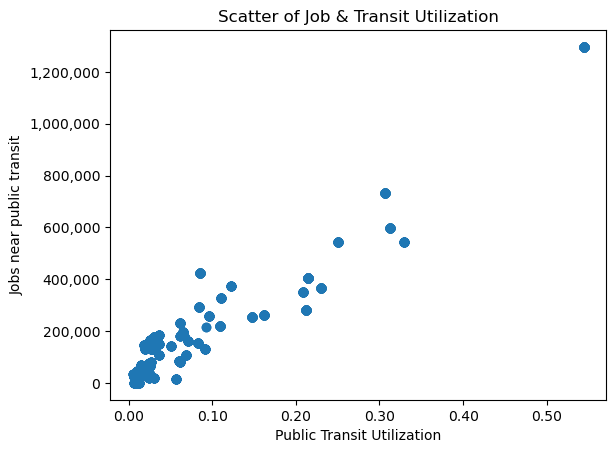

In [1169]:
plt.scatter(
    rail_df['%transit'],
    rail_df['jobs']
)
plt.xlabel('Public Transit Utilization')
plt.ylabel('Jobs near public transit')
plt.title(f'Scatter of Job & Transit Utilization')
plt.gca().yaxis.set_major_formatter('{:,.0f}'.format)
plt.gca().xaxis.set_major_formatter('{:,.2f}'.format)
plt.show()

In [1170]:
# calculate Pearson correlation between '%transit' and 'jobs'
pearson_corr = rail_df["%transit"].corr(rail_df["jobs"], method="pearson")

# display the result and interpretation
print(f"Pearson Correlation: {pearson_corr:.4f}")
if abs(pearson_corr) < 0.3:
    print("Interpretation: No or weak linear correlation between jobs and transit utilization.")
elif 0.3 <= abs(pearson_corr) < 0.7:
    print("Interpretation: Moderate linear correlation between jobs and transit utilization.")
else:
    print("Interpretation: Strong linear correlation between jobs and transit utilization.")

Pearson Correlation: 0.9470
Interpretation: Strong linear correlation between jobs and transit utilization.


In [1171]:
# perform the Pearson correlation test if correlation is statistically significant 
corr_stat, p_value = pearsonr(rail_df["%transit"], rail_df["jobs"])

# display the correlation statistic and p-value
print(f"Pearson Correlation Coefficient: {corr_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# interpretation based on p-value with alpha = 0.05 as the significance level 
alpha = 0.05 
if p_value > alpha:
    print("Fail to reject H0: No significant correlation between jobs and transit utilization (correlation = 0).")
else:
    print("Reject H0: Significant correlation exists between jobs and transit utilization (correlation != 0).")

Pearson Correlation Coefficient: 0.9470
P-value: 0.0000
Reject H0: Significant correlation exists between jobs and transit utilization (correlation != 0).


### Which mode of rail transportation is most popular? Does it vary by population of a city? Do big cities have more variety in modes of rail transportation?  

Top 5: Light Rail, Commuter Rail, Heavy Rail, Street Car, Monorail

In [1174]:
# Most popular mode of transportation
q5_popularRail = rail_df.groupby('Mode')['Mode'].count().sort_values(ascending=False)

q5_popularRail.head()

Mode
LR    579
CR    551
HR    303
SR    254
MG    116
Name: Mode, dtype: int64

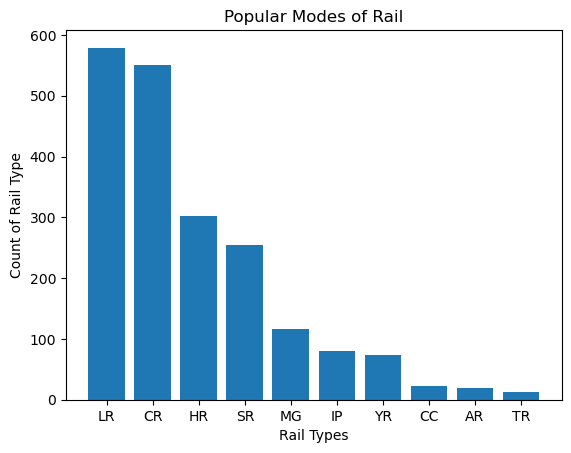

In [1175]:
plt.bar(q5_popularRail.index, q5_popularRail)
plt.title('Popular Modes of Rail')
plt.xlabel('Rail Types')
plt.ylabel('Count of Rail Type')
plt.show()

In [1176]:
# Do big cities have more variety in modes of transportation
# Part A: Modes of Transport
q5_cityModesVariety = rail_df[['city','population']].drop_duplicates().drop_duplicates(subset=['city'], keep='first')

modesList = []
for city in tuple(q5_cityModesVariety['city'].unique()):
    modesList.append(rail_df[rail_df['city'] == city]['Mode'].unique())

q5_cityModesVariety['Modes of Transportation'] = [ ', '.join(modes) for modes in modesList ]
q5_cityModesVariety['Total Modes'] = [ len(modes) for modes in modesList ] 

q5_cityModesVariety = q5_cityModesVariety.sort_values(by='Total Modes', ascending=False)

q5_cityModesVariety.head()

,city,population,Modes of Transportation,Total Modes
1,Portland,641885,"LR, CR, SR, YR, TR",5
0,Seattle,734731,"LR, MG, CR, SR",4
19,Philadelphia,1593208,"CR, HR, LR, SR",4
49,Dallas,1330798,"CR, LR, SR",3
54,Oakland,437832,"HR, MG, YR",3


In [1177]:
# Part B: City Classification
# Source for classes: https://www.oecd.org/en/data/indicators/urban-population-by-city-size.html

bins = [5000,50000,200000,500000,1500000,np.inf]
labels = ['Town','Small City','City','Metropolis','Large Metropolis']

q5_cityModesVariety['City Class'] = pd.cut(
    q5_cityModesVariety['population'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
).astype('category')

q5_cityModesVariety.head()

,city,population,Modes of Transportation,Total Modes,City Class
1,Portland,641885,"LR, CR, SR, YR, TR",5,Metropolis
0,Seattle,734731,"LR, MG, CR, SR",4,Metropolis
19,Philadelphia,1593208,"CR, HR, LR, SR",4,Large Metropolis
49,Dallas,1330798,"CR, LR, SR",3,Metropolis
54,Oakland,437832,"HR, MG, YR",3,City


In [1178]:
# Part C: Average modes per classification

q5_cityModesVarietyAverage =  q5_cityModesVariety.groupby('City Class', observed=False)['Total Modes'].mean().sort_values(ascending=False)

display(q5_cityModesVarietyAverage)

City Class
Large Metropolis    2.333333
Metropolis          1.956522
City                1.812500
Small City          1.545455
Town                1.000000
Name: Total Modes, dtype: float64

In [1179]:
# Most popular modes of transportation by city class size
bins = [5000,50000,200000,500000,1500000,np.inf]
labels = ['Town','Small City','City','Metropolis','Large Metropolis']

q5_popularModes = rail_df.copy()
q5_popularModes['City Class'] = pd.cut(
    q5_popularModes['population'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
).astype('category')


In [1180]:
q5_popularModesByClass = q5_popularModes.groupby(['City Class','Mode'], observed=True)['Mode'].count().sort_values(ascending=False)

one_class, dropIndices = set(), []
for cityClass in q5_popularModesByClass.index:
    if cityClass[0] not in one_class:
        one_class.add(cityClass[0])
    else:
        dropIndices += [cityClass]
q5_popularModesByClass = q5_popularModesByClass.drop(dropIndices)

display(q5_popularModesByClass)

City Class        Mode
Metropolis        LR      266
City              LR      201
Large Metropolis  CR      120
Small City        CR      100
Town              CR       99
Name: Mode, dtype: int64

### How does fare price impact ridership? Does higher average cost per trip lead to higher average fare per trip and vice versa? Does population or service area impact fare price?  

In [1182]:
# Filter the data to only show results for the year 2024
rail_2024 = rail_df[rail_df['Year']==2024].reset_index(drop=True)
rail_2024 = rail_2024.rename(columns={'Avg Fares Per Trip FY': 'Avg_Fares_Per_Trip_FY', 'Avg Cost Per Trip FY': 'Avg_Cost_Per_Trip_FY'})

In [1183]:
# Descriptive statistics for average fares per trip
print("Statistics for Avg_Fares_Per_Trip_FY")
print("-"*50)
print(f'count: {rail_2024['Avg_Fares_Per_Trip_FY'].count()}')
print(f'mean: ${rail_2024['Avg_Fares_Per_Trip_FY'].mean():.2f}')
print(f'min: ${rail_2024['Avg_Fares_Per_Trip_FY'].min():.2f}')
print(f"25%: ${rail_2024['Avg_Fares_Per_Trip_FY'].quantile(0.25):.2f}")
print(f'median: ${rail_2024['Avg_Fares_Per_Trip_FY'].median():.2f}')
print(f"75%: ${rail_2024['Avg_Fares_Per_Trip_FY'].quantile(0.75):.2f}")
print(f'max: ${rail_2024['Avg_Fares_Per_Trip_FY'].max():.2f}')
print(f'std: {rail_2024['Avg_Fares_Per_Trip_FY'].std()}')

Statistics for Avg_Fares_Per_Trip_FY
--------------------------------------------------
count: 109
mean: $3.89
min: $0.00
25%: $0.41
median: $0.99
75%: $2.85
max: $160.25
std: 15.82665561950268


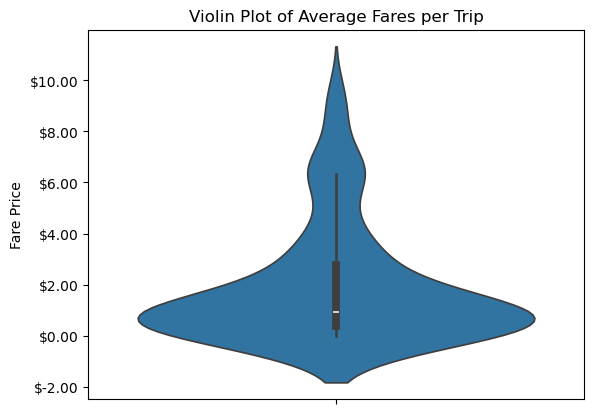

In [1184]:
# Create a histogram for 'Avg_Fares_Per_Trip_FY' filtering out for outliers
rail_no_outlier = rail_2024[rail_2024['Avg_Fares_Per_Trip_FY'] < 10]

# Create a violin plot
sns.violinplot(x=None, y="Avg_Fares_Per_Trip_FY", data=rail_no_outlier)  # set x to 'None' for no grouping
plt.title("Violin Plot of Average Fares per Trip")
plt.ylabel("Fare Price")
plt.gca().yaxis.set_major_formatter('${:.2f}'.format)
plt.show()

#### Fare price and ridership

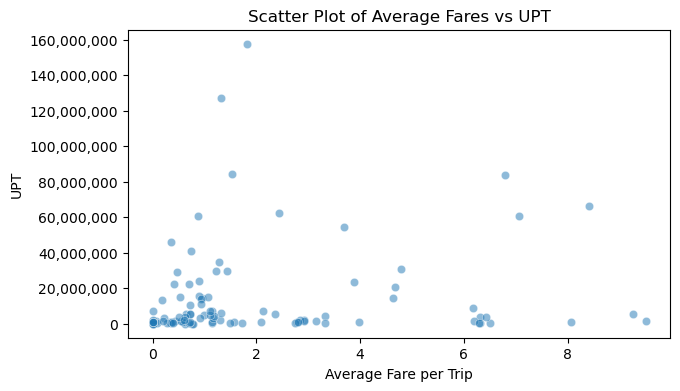

In [1186]:
# create a scatter plot for Average_Fares_Per_Trip_FY (x) vs UPT (y)
plt.figure(figsize=(7, 4))
sns.scatterplot(x="Avg_Fares_Per_Trip_FY", y="UPT", data=rail_no_outlier, alpha=0.5) 
plt.title("Scatter Plot of Average Fares vs UPT")
plt.xlabel("Average Fare per Trip")
plt.ylabel("UPT")
plt.gca().yaxis.set_major_formatter('{:,.0f}'.format)

plt.show()

In [1187]:
# calculate Pearson correlation between 'Avg_Fares_Per_Trip_FY' and 'UPT'
pearson_corr = rail_2024["Avg_Fares_Per_Trip_FY"].corr(rail_2024["UPT"], method="pearson")

# display the result and interpretation
print(f"Pearson Correlation: {pearson_corr:.4f}")
if abs(pearson_corr) < 0.3:
    print("Interpretation: No or weak linear correlation between average fare per trip and UPT.")
elif 0.3 <= abs(pearson_corr) < 0.7:
    print("Interpretation: Moderate linear correlation between average fare per trip and UPT.")
else:
    print("Interpretation: Strong linear correlation between average fare per trip and UPT.")

Pearson Correlation: -0.0405
Interpretation: No or weak linear correlation between average fare per trip and UPT.


In [1188]:
# perform the Pearson correlation test if correlation is statistically significant 
corr_stat, p_value = pearsonr(rail_2024["Avg_Fares_Per_Trip_FY"], rail_2024["UPT"])

# display the correlation statistic and p-value
print(f"Pearson Correlation Coefficient: {corr_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# interpretation based on p-value with alpha = 0.05 as the significance level 
alpha = 0.05 
if p_value > alpha:
    print("Fail to reject H0: No significant correlation between average fare price per trip and UPT (correlation = 0).")
else:
    print("Reject H0: Significant correlation exists between average fare price per trip and UPT (correlation != 0).")

Pearson Correlation Coefficient: -0.0405
P-value: 0.6759
Fail to reject H0: No significant correlation between average fare price per trip and UPT (correlation = 0).


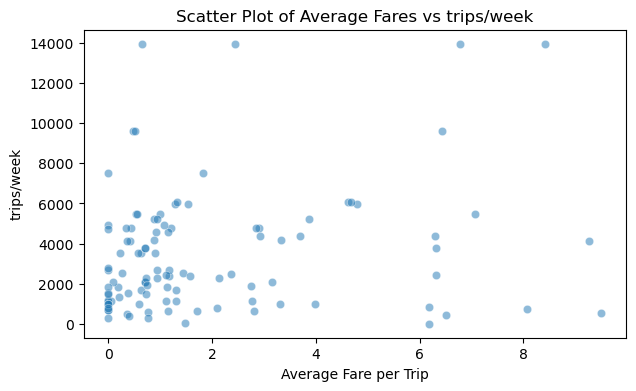

In [1189]:
# create a scatter plot for Average_Fares_Per_Trip_FY (x) vs trips/week (y)
plt.figure(figsize=(7, 4))
sns.scatterplot(x="Avg_Fares_Per_Trip_FY", y="trips/week", data=rail_no_outlier, alpha=0.5) 
plt.title("Scatter Plot of Average Fares vs trips/week")
plt.xlabel("Average Fare per Trip")
plt.ylabel("trips/week")

plt.show()

In [1190]:
# calculate Pearson correlation between 'Avg_Fares_Per_Trip_FY' and 'trips/week'
pearson_corr = rail_2024["Avg_Fares_Per_Trip_FY"].corr(rail_2024["trips/week"], method="pearson")

# display the result and interpretation
print(f"Pearson Correlation: {pearson_corr:.4f}")
if abs(pearson_corr) < 0.3:
    print("Interpretation: No or weak linear correlation between average fare per trip and trips/week.")
elif 0.3 <= abs(pearson_corr) < 0.7:
    print("Interpretation: Moderate linear correlation between average fare per trip and trips/week.")
else:
    print("Interpretation: Strong linear correlation between average fare per trip and trips/week.")

Pearson Correlation: -0.0744
Interpretation: No or weak linear correlation between average fare per trip and trips/week.


In [1191]:
# perform the Pearson correlation test if correlation is statistically significant 
corr_stat, p_value = pearsonr(rail_2024["Avg_Fares_Per_Trip_FY"], rail_2024["trips/week"])

# display the correlation statistic and p-value
print(f"Pearson Correlation Coefficient: {corr_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# interpretation based on p-value with alpha = 0.05 as the significance level 
alpha = 0.05 
if p_value > alpha:
    print("Fail to reject H0: No significant correlation between average fare price per trip and trips/week (correlation = 0).")
else:
    print("Reject H0: Significant correlation exists between average fare price per trip and trips/week (correlation != 0).")

Pearson Correlation Coefficient: -0.0744
P-value: 0.4419
Fail to reject H0: No significant correlation between average fare price per trip and trips/week (correlation = 0).


#### Cost per trip and fare price

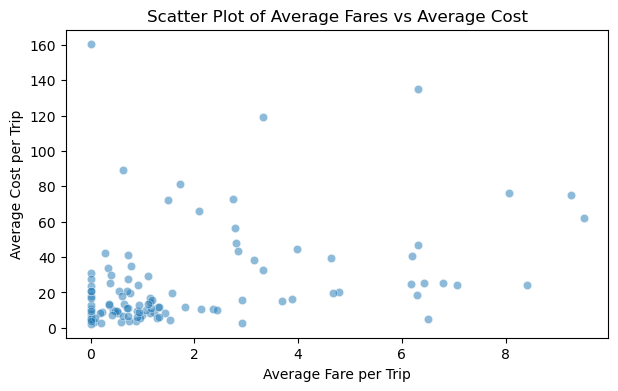

In [1193]:
# create a scatter plot for Average_Fares_Per_Trip_FY (x) vs Avg_Cost_Per_Trip_FY (y)
plt.figure(figsize=(7, 4))
sns.scatterplot(x="Avg_Fares_Per_Trip_FY", y="Avg_Cost_Per_Trip_FY", data=rail_no_outlier, alpha=0.5) 
plt.title("Scatter Plot of Average Fares vs Average Cost")
plt.xlabel("Average Fare per Trip")
plt.ylabel("Average Cost per Trip")

plt.show()

In [1194]:
# calculate Pearson correlation between 'Avg_Fares_Per_Trip_FY' and 'Avg_Cost_Per_Trip_FY'
pearson_corr = rail_2024["Avg_Fares_Per_Trip_FY"].corr(rail_2024["Avg_Cost_Per_Trip_FY"], method="pearson")

# display the result and interpretation
print(f"Pearson Correlation: {pearson_corr:.4f}")
if abs(pearson_corr) < 0.3:
    print("Interpretation: No or weak linear correlation between average fare and cost per trip.")
elif 0.3 <= abs(pearson_corr) < 0.7:
    print("Interpretation: Moderate linear correlation between average fare and cost per trip.")
else:
    print("Interpretation: Strong linear correlation between average fare and cost per trip.")

Pearson Correlation: 0.6827
Interpretation: Moderate linear correlation between average fare and cost per trip.


In [1195]:
# perform the Pearson correlation test if correlation is statistically significant 
corr_stat, p_value = pearsonr(rail_2024["Avg_Fares_Per_Trip_FY"], rail_2024["Avg_Cost_Per_Trip_FY"])

# display the correlation statistic and p-value
print(f"Pearson Correlation Coefficient: {corr_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# interpretation based on p-value with alpha = 0.05 as the significance level 
alpha = 0.05 
if p_value > alpha:
    print("Fail to reject H0: No significant correlation between average fare price and cost per trip (correlation = 0).")
else:
    print("Reject H0: Significant correlation exists between average fare price and cost per trip (correlation != 0).")

Pearson Correlation Coefficient: 0.6827
P-value: 0.0000
Reject H0: Significant correlation exists between average fare price and cost per trip (correlation != 0).


#### Does population impact fare price?

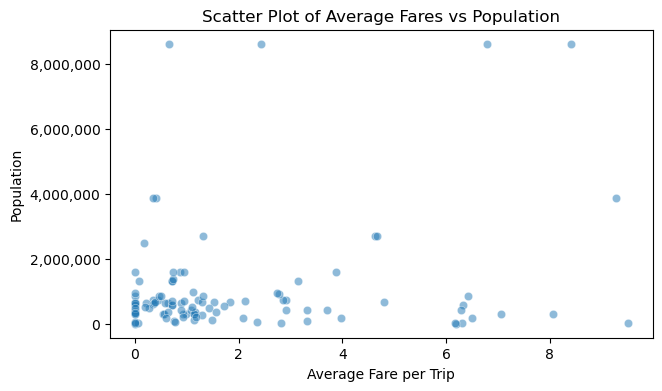

In [1197]:
# create a scatter plot for Average_Fares_Per_Trip_FY (x) vs population (y)
plt.figure(figsize=(7, 4))
sns.scatterplot(x="Avg_Fares_Per_Trip_FY", y="population", data=rail_no_outlier, alpha=0.5) 
plt.title("Scatter Plot of Average Fares vs Population")
plt.xlabel("Average Fare per Trip")
plt.ylabel("Population")
plt.gca().yaxis.set_major_formatter('{:,.0f}'.format)
plt.show()

In [1198]:
# calculate Pearson correlation between 'Avg_Fares_Per_Trip_FY' and 'Population'
pearson_corr = rail_2024["Avg_Fares_Per_Trip_FY"].corr(rail_2024["population"], method="pearson")

# display the result and interpretation
print(f"Pearson Correlation: {pearson_corr:.4f}")
if abs(pearson_corr) < 0.3:
    print("Interpretation: No or weak linear correlation between average fare per trip and population.")
elif 0.3 <= abs(pearson_corr) < 0.7:
    print("Interpretation: Moderate linear correlation between average fare per trip and population.")
else:
    print("Interpretation: Strong linear correlation between average fare per trip and population.")

Pearson Correlation: -0.0274
Interpretation: No or weak linear correlation between average fare per trip and population.


In [1199]:
# perform the Pearson correlation test if correlation is statistically significant 
corr_stat, p_value = pearsonr(rail_2024["Avg_Fares_Per_Trip_FY"], rail_2024["population"])

# display the correlation statistic and p-value
print(f"Pearson Correlation Coefficient: {corr_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# interpretation based on p-value with alpha = 0.05 as the significance level 
alpha = 0.05 
if p_value > alpha:
    print("Fail to reject H0: No significant correlation between average fare price per trip and population (correlation = 0).")
else:
    print("Reject H0: Significant correlation exists between average fare price per trip and population (correlation != 0).")

Pearson Correlation Coefficient: -0.0274
P-value: 0.7777
Fail to reject H0: No significant correlation between average fare price per trip and population (correlation = 0).


In [1200]:
# Turn population into a categorical variable by binning it based on population
bins = [5000,200000,500000,1000000,np.inf]
labels = ['Town/Small City','City','Metropolis','Large Metropolis']

rail_2024['City_Class'] = pd.cut(
    rail_2024['population'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
).astype('category')

In [1201]:
rail_2024['City_Class'].value_counts()

City_Class
Metropolis          39
City                28
Town/Small City     21
Large Metropolis    21
Name: count, dtype: int64

In [1202]:
# fit the ANOVA model
fit = ols("Avg_Fares_Per_Trip_FY ~ City_Class", data=rail_2024).fit()

# display the ANOVA table
anova_table = sm.stats.anova_lm(fit, typ=2)  # Type 2 ANOVA
print(anova_table)

# extract the p-value using iloc
p_value = anova_table["PR(>F)"].iloc[0]
print(f"P-value: {p_value:.8f}")

# interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject H0: The average fare price are significantly different across different population sizes.")
else:
    print("Fail to reject H0: No significant difference in average fare price across different population sizes.")

                  sum_sq     df         F    PR(>F)
City_Class    706.316465    3.0  0.938329  0.424974
Residual    26345.850570  105.0       NaN       NaN
P-value: 0.42497356
Fail to reject H0: No significant difference in average fare price across different population sizes.


In [1203]:
# perform Kruskal-Wallis test
groups = [rail_2024[rail_2024["City_Class"] == city_class]["Avg_Fares_Per_Trip_FY"].dropna() for city_class in rail_2024["City_Class"].unique()]

stat, p_value = kruskal(*groups)

# display the result
print(f"Kruskal-Wallis Test Statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

# interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject H0: The median heights are significantly different across different population sizes.")
else:
    print("Fail to reject H0: No significant difference in median heights across different population sizes.")

Kruskal-Wallis Test Statistic: 6.3872
P-value: 0.0942
Fail to reject H0: No significant difference in median heights across different population sizes.


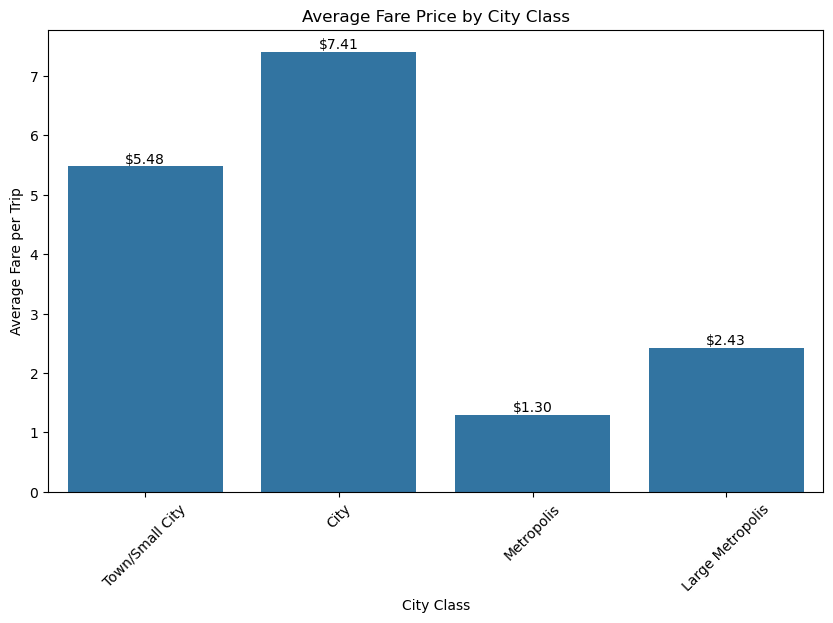

In [1204]:
city_class = rail_2024.groupby("City_Class", observed=True).agg({"Avg_Fares_Per_Trip_FY": "mean"})

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="City_Class", y="Avg_Fares_Per_Trip_FY", data=city_class)

for container in ax.containers:
    for bar in container:
        height = bar.get_height() 
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            height, 
            f"${(height):,.2f}",  
            ha='center', va='bottom', fontsize=10, color='black')

plt.title("Average Fare Price by City Class")
plt.xlabel("City Class")
plt.ylabel("Average Fare per Trip")
plt.xticks(rotation=45)  # rotate x-axis labels for better readability

plt.show()

#### Does service area impact fare price?

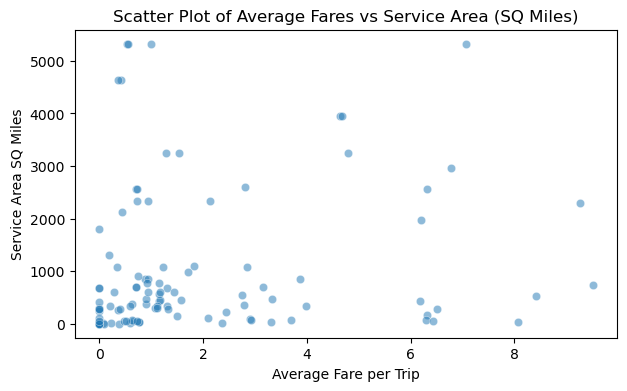

In [1206]:
# create a scatter plot for Average_Fares_Per_Trip_FY (x) vs Service Area SQ Miles (y)
plt.figure(figsize=(7, 4))
sns.scatterplot(x="Avg_Fares_Per_Trip_FY", y="Service Area SQ Miles", data=rail_no_outlier, alpha=0.5) 
plt.title("Scatter Plot of Average Fares vs Service Area (SQ Miles)")
plt.xlabel("Average Fare per Trip")
plt.ylabel("Service Area SQ Miles")
plt.show()

In [1207]:
# calculate Pearson correlation between 'Avg_Fares_Per_Trip_FY' and 'Avg_Cost_Per_Trip_FY'
pearson_corr = rail_2024["Avg_Fares_Per_Trip_FY"].corr(rail_2024["Service Area SQ Miles"], method="pearson")

# display the result and interpretation
print(f"Pearson Correlation: {pearson_corr:.4f}")
if abs(pearson_corr) < 0.3:
    print("Interpretation: No or weak linear correlation between average fare per trip and service area.")
elif 0.3 <= abs(pearson_corr) < 0.7:
    print("Interpretation: Moderate linear correlation between average fare per trip and service area.")
else:
    print("Interpretation: Strong linear correlation between average fare per trip and service area.")

Pearson Correlation: 0.0076
Interpretation: No or weak linear correlation between average fare per trip and service area.


In [1208]:
# perform the Pearson correlation test if correlation is statistically significant 
corr_stat, p_value = pearsonr(rail_2024["Avg_Fares_Per_Trip_FY"], rail_2024["Service Area SQ Miles"])

# display the correlation statistic and p-value
print(f"Pearson Correlation Coefficient: {corr_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# interpretation based on p-value with alpha = 0.05 as the significance level 
alpha = 0.05 
if p_value > alpha:
    print("Fail to reject H0: No significant correlation between average fare price per trip and service area (correlation = 0).")
else:
    print("Reject H0: Significant correlation exists between average fare price per trip and service area (correlation != 0).")

Pearson Correlation Coefficient: 0.0076
P-value: 0.9371
Fail to reject H0: No significant correlation between average fare price per trip and service area (correlation = 0).


### Which factors can be used to predict how much ridership a city will have in the future? 

In [1210]:
# Filter data to only use 2024 data because some variables (i.e., population, rank, & fares) are only for 2024
rail_2024 = rail_df[rail_df['Year']==2024].reset_index(drop=True).copy()

# Filter a dataframe to only incldue the variables we want
rail_2024_filter = rail_2024[['Mode','UPT','VRM','Avg Fares Per Trip FY','jobs','routes','tci']]

# Create dummy variables for our categorical variables
dummies = pd.get_dummies(rail_2024_filter['Mode'])

# Concatenate the original DataFrame with the new dummy DataFrame and drop the old columns
rail_2024_filter = pd.concat([rail_2024_filter, dummies], axis=1)
columns_to_drop = 'Mode'
rail_2024_filter = rail_2024_filter.drop(columns=columns_to_drop)

# Choose which variables we want to use to predict our y variable (UPT).
X = rail_2024_filter.drop('UPT', axis=1).values
y = rail_2024_filter['UPT']

# Split the data using a 80/20 training/testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

#### Linear Regression

In [1212]:
# Create a linear regression model to predict ridership (UPT)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Get predictions from the model
#y_pred = lin_reg.predict(X_test)
#print(y_pred)

# Get the R-squared for the model
print(f'R-squared score: {lin_reg.score(X_test, y_test)}')

# Get the intercept
print(f'Intercept: {lin_reg.intercept_}')

# Get the coefficients
print(f'Coefficients:\n {lin_reg.coef_}')

R-squared score: 0.7261871574142679
Intercept: 2428069.1100117974
Coefficients:
 [ 1.26030972e+00 -1.21041983e+05 -1.38298962e+00  3.85475929e+04
  7.47451772e+05  1.52512510e+07 -3.62655575e+06 -6.96886180e+06
  6.26041051e+06 -3.97330678e+06  4.95522954e+06 -2.36784190e+06
 -2.50427259e+06 -3.21559318e+06 -3.81045902e+06]


We got a R-squared score of ___ for our model, which means our model is not doing a good job of predicting UPT using our current variables. We can experiment using different variables to see if we can get a better model.

#### Lasso Regression

In [1269]:
# Create a Lasso regression model to predict ridership (UPT)
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train, y_train)

# Get the R-squared for the model
print(f'R-squared score: {lasso_reg.score(X_test, y_test)}')

# Get the intercept
print(f'Intercept: {lasso_reg.intercept_}')

# Get the coefficients
print(f'Coefficients:\n {lasso_reg.coef_}')

R-squared score: 0.7261871443717846
Intercept: 2322599.655709699
Coefficients:
 [ 1.26030973e+00 -1.21040923e+05 -1.38297966e+00  3.85473158e+04
  7.47450875e+05  1.53565414e+07 -3.52107913e+06 -6.86339828e+06
  6.36587936e+06 -3.86783374e+06  5.06069925e+06 -2.26237001e+06
 -2.39880066e+06 -3.11011277e+06 -3.70498706e+06]


C:\Users\staro\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.733e+14, tolerance: 5.931e+12
  model = cd_fast.enet_coordinate_descent(


#### Decision Tree Regression

In [1215]:
# Create a Decision Tree regression model to predict ridership (UPT)
dt_reg = DecisionTreeRegressor(max_depth=12)
dt_reg.fit(X_train, y_train)

# Get the R-squared for the model
print(f'R-squared score: {dt_reg.score(X_test, y_test)}')

R-squared score: 0.9193832010772607
